# Q2: Dimensionality Reduction
## Dimensionality Reduction: Autoencoder vs. PCA

This notebook explores two dimensionality reduction techniques: Autoencoders and Principal Component Analysis (PCA). We'll apply these methods to the Fashion-MNIST dataset, a collection of 70,000 grayscale images of clothing items.

Our objectives are to:

1. Implement an autoencoder using PyTorch
2. Apply PCA using scikit-learn
3. Compare the performance of both methods across various reduced dimensions

Dimensionality reduction is crucial in data science for several reasons:

- It can accelerate machine learning algorithms
- It helps in visualizing high-dimensional data
- It can reduce storage requirements for large datasets

By the end of this notebook, you'll understand the strengths and limitations of autoencoders and PCA in the context of image data compression.

Let's begin by setting up our environment and loading the necessary libraries:


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import struct
import os

In [2]:
# Set random seed for reproducibility
torch.manual_seed(3)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
num_epochs = 50
learning_rate = 0.001

## Data Preprocessing and Loading

For the Fashion-MNIST dataset, we implement a custom dataset class to efficiently handle data loading and preprocessing. This approach ensures optimal performance and flexibility in our data pipeline.

Key components of our data preprocessing:

1. Custom Dataset Class: We define a `FashionMNISTDataset` class that inherits from PyTorch's `Dataset`. This class manages the reading of image and label files, and applies necessary transformations.
2. Data Transformation: We use a simple lambda function to convert our data into PyTorch tensors and add a channel dimension.
3. File Path Management: We construct absolute paths to our data files, ensuring compatibility across different system environments.
4. Data Loaders: We create separate data loaders for training and testing sets, enabling efficient batching and shuffling of data.

The implementation of these components can be found in the following code blocks:


In [3]:
# Data Preprocessing
transform = lambda x: torch.tensor(x).unsqueeze(0)

class FashionMNISTDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.read_idx_file(images_file)
        self.labels = self.read_idx_file(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32) / 255.0
        label = int(self.labels[idx])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def read_idx_file(self, filename):
        with open(filename, 'rb') as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4))
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
# Get the current working directory
current_dir = os.getcwd()
# Get the parent directory, which is the root directory of the project
root_dir = os.path.dirname(current_dir)

# Construct absolute paths
train_images_path = os.path.join(root_dir, 'data', 'fashion', 'train-images-idx3-ubyte')
train_labels_path = os.path.join(root_dir, 'data', 'fashion', 'train-labels-idx1-ubyte')
test_images_path = os.path.join(root_dir, 'data', 'fashion', 't10k-images-idx3-ubyte')
test_labels_path = os.path.join(root_dir, 'data', 'fashion', 't10k-labels-idx1-ubyte')

In [5]:
# Create datasets
train_dataset = FashionMNISTDataset(
    images_file=train_images_path,
    labels_file=train_labels_path,
    transform=transform
)

test_dataset = FashionMNISTDataset(
    images_file=test_images_path,
    labels_file=test_labels_path,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This preprocessing pipeline transforms our raw Fashion-MNIST data into a format suitable for training our autoencoder and applying PCA. It ensures that our data is properly normalized, batched, and ready for efficient processing by our models.

## Autoencoder Model

We now define our autoencoder architecture, which is crucial for dimensionality reduction. The model consists of two main components:

1. Encoder: Compresses the input data into a lower-dimensional representation.
2. Decoder: Reconstructs the original data from the compressed representation.

Our autoencoder is implemented as a PyTorch module with the following structure:


In [6]:
class Autoencoder(nn.Module):
    def __init__(self, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoded_dim = encoded_dim
        
        # Encoder
        self.encoder_conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.encoder_fc = nn.Linear(32 * 7 * 7, encoded_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(encoded_dim, 32 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(x.size(0), -1)
        x = self.encoder_fc(x)
        return x

    def decode(self, x):
        x = self.decoder_fc(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

Key aspects of this implementation:

1. The encoder uses two convolutional layers followed by a fully connected layer to compress the input.
2. The decoder mirrors this structure, using a fully connected layer followed by two transposed convolutional layers to reconstruct the image.
3. We use ReLU activation functions for intermediate layers and a sigmoid activation for the final output layer.
4. The `encoded_dim` parameter allows us to flexibly adjust the dimensionality of the compressed representation.

This architecture enables our autoencoder to learn efficient, lower-dimensional representations of the Fashion-MNIST images. By varying the `encoded_dim`, we can explore different levels of compression and their impact on reconstruction quality.

## Training Function

To streamline our autoencoder training process, we define a dedicated function. This function encapsulates the entire training loop, including both training and validation steps. Here's an overview of its key components:

1. Epoch iteration: The function runs for a specified number of epochs.
2. Training phase: In each epoch, it processes the training data, computes loss, and updates model parameters.
3. Validation phase: After each training epoch, it evaluates the model on the test set.
4. Loss tracking: It records both training and test losses for later analysis.

The implementation of this function is as follows:

In [7]:
def train_autoencoder(model, train_loader, test_loader, num_epochs, optimizer, criterion):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

This function takes the model, data loaders, number of epochs, optimizer, and loss criterion as inputs. It returns the training and test loss histories, which we can use to visualize the learning progress.
Key aspects of this implementation:

1. We use `model.train()` and `model.eval()` to switch between training and evaluation modes.
2. The function handles both autoencoder training (reconstruction) and dimensionality reduction (encoding).
3. We use `torch.no_grad()` during evaluation to disable gradient computation and save memory.

By encapsulating the training process in a function, we enhance code reusability and make it easier to train autoencoders with different configurations or on different datasets.

## Visualization Function

To effectively evaluate the performance of our dimensionality reduction techniques, we implement a visualization function. This function allows us to compare original images with their reconstructed counterparts visually. Key aspects of this function include:

1. Side-by-side display of original and reconstructed images
2. Clear labeling of the dimensionality reduction method and encoded dimension
3. Efficient use of matplotlib for creating the visualization

The implementation of this function is as follows:


In [8]:
def visualize_results(original, reconstructed, method, dim):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(5):
        axes[0, i].imshow(original[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f'{method} Reconstruction (dim={dim})')
    plt.tight_layout()
    plt.show()

This function takes four parameters:

- `original`: A batch of original images
- `reconstructed`: A batch of reconstructed images
- `method`: The dimensionality reduction method used (e.g., "PCA" or "Autoencoder")
- `dim`: The dimension of the encoded representation

The function creates a figure with two rows:

1. The top row displays the original images
2. The bottom row shows the corresponding reconstructed images

By using this visualization function, we can:

- Quickly assess the quality of reconstructions
- Compare the performance of different dimensionality reduction techniques
- Observe how the encoded dimension affects reconstruction quality

This visual feedback is crucial for understanding the trade-offs between compression and reconstruction fidelity in our dimensionality reduction experiments.


## Main Execution

In this section, we conduct a comprehensive comparison between PCA and our autoencoder for dimensionality reduction. We evaluate both methods across multiple reduced dimensions to assess their performance and reconstruction capabilities.

Our experimental procedure involves the following steps:

1. Iterate through different reduced dimensions (1, 2, and 3).
2. For each dimension:
    - Apply PCA to the dataset and measure reconstruction error.
    - Train an autoencoder with the corresponding encoded dimension.
    - Visualize and compare the results of both methods.

This approach allows us to:

- Assess how the reduced dimension affects reconstruction quality for each method.
- Compare the computational efficiency of PCA versus autoencoder training.
- Visualize the reconstructed images to qualitatively evaluate performance.

The implementation of our main execution loop is as follows:



Dimensionality: 1
PCA Reconstruction Error: 0.061376782373237765


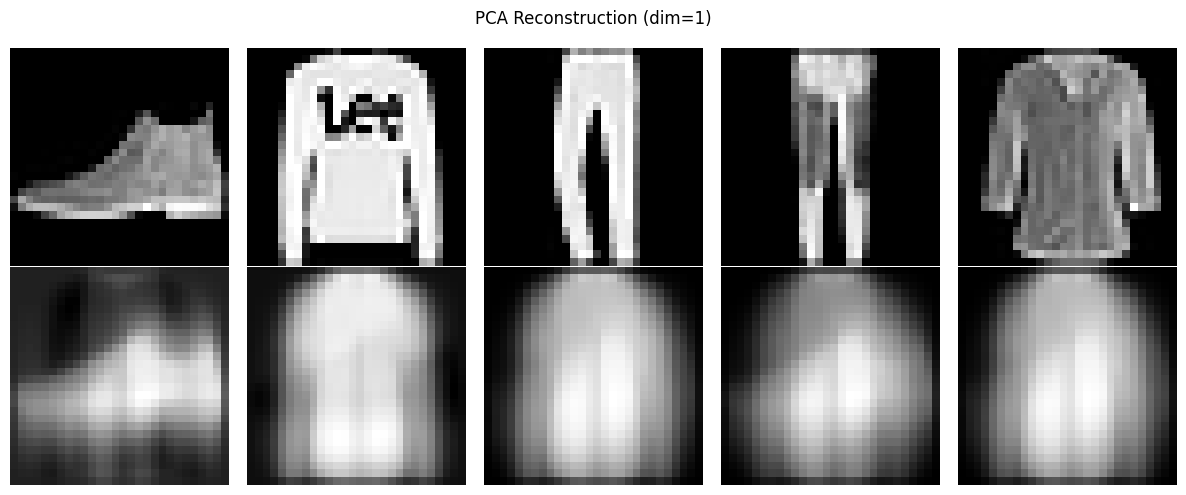


Dimensionality: 2
PCA Reconstruction Error: 0.04609611423815835


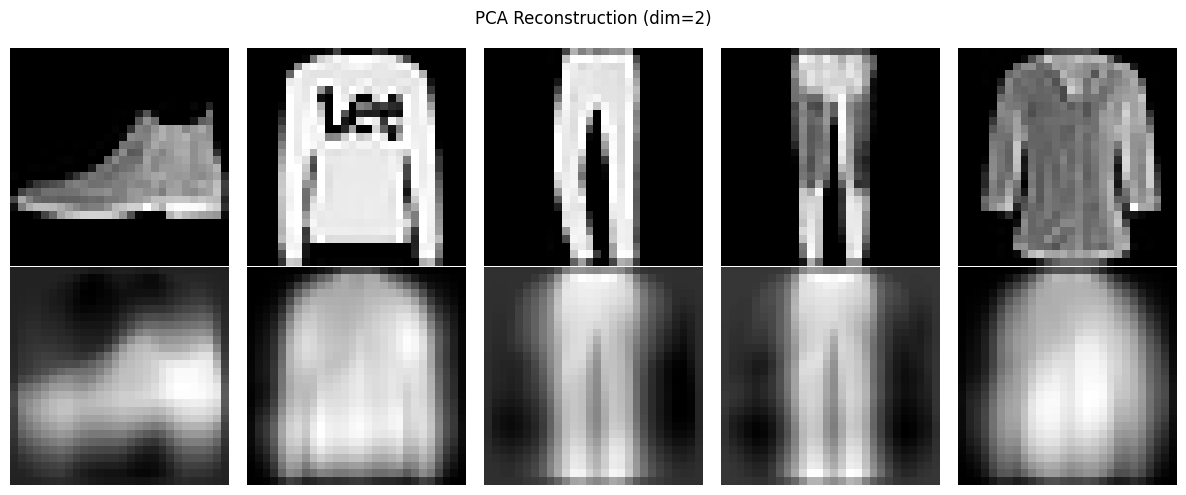


Dimensionality: 3
PCA Reconstruction Error: 0.04089195746373651


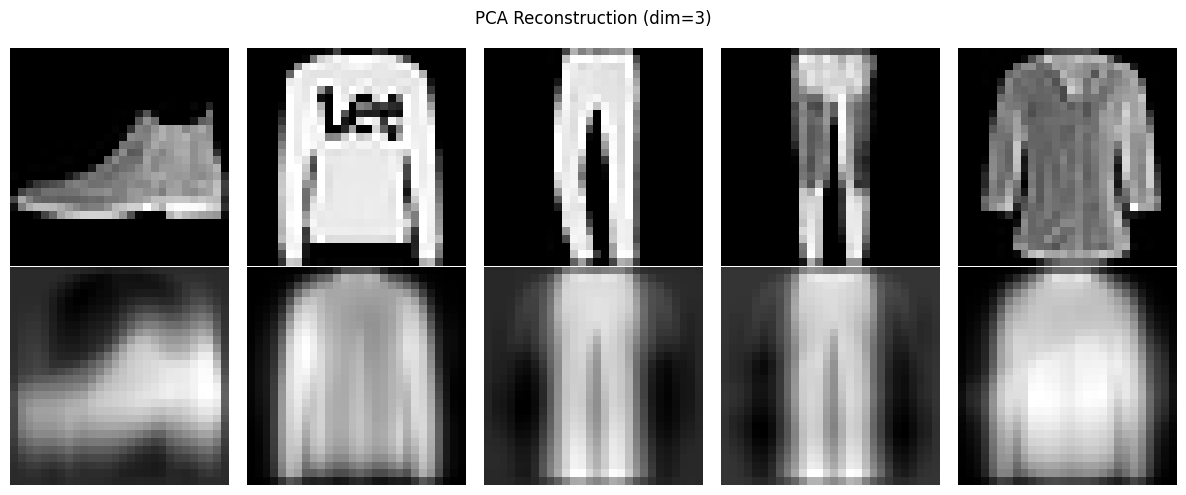

In [9]:
for dim in [1, 2, 3]:
    print(f"\nDimensionality: {dim}")
    
    # PCA
    pca = PCA(n_components=dim)
    train_data = train_dataset.images.reshape(-1, 28*28) / 255.0
    test_data = test_dataset.images.reshape(-1, 28*28) / 255.0
    
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    pca_reconstructed = pca.inverse_transform(pca_test)
    
    print("PCA Reconstruction Error:", np.mean((test_data - pca_reconstructed)**2))
    
    visualize_results(test_data[:5], pca_reconstructed[:5], "PCA", dim)
    


Dimensionality: 1


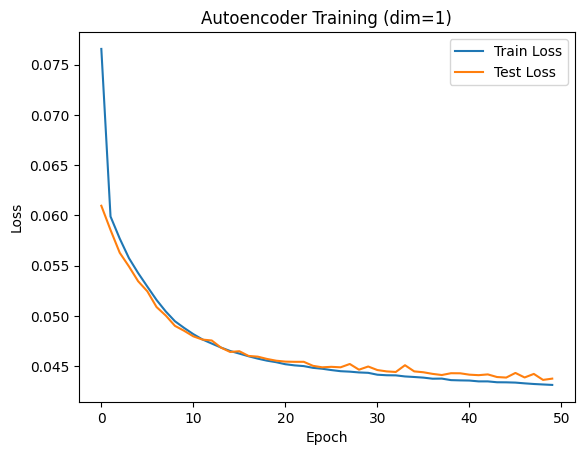

CAE Reconstruction Error (50 epochs): 0.043763


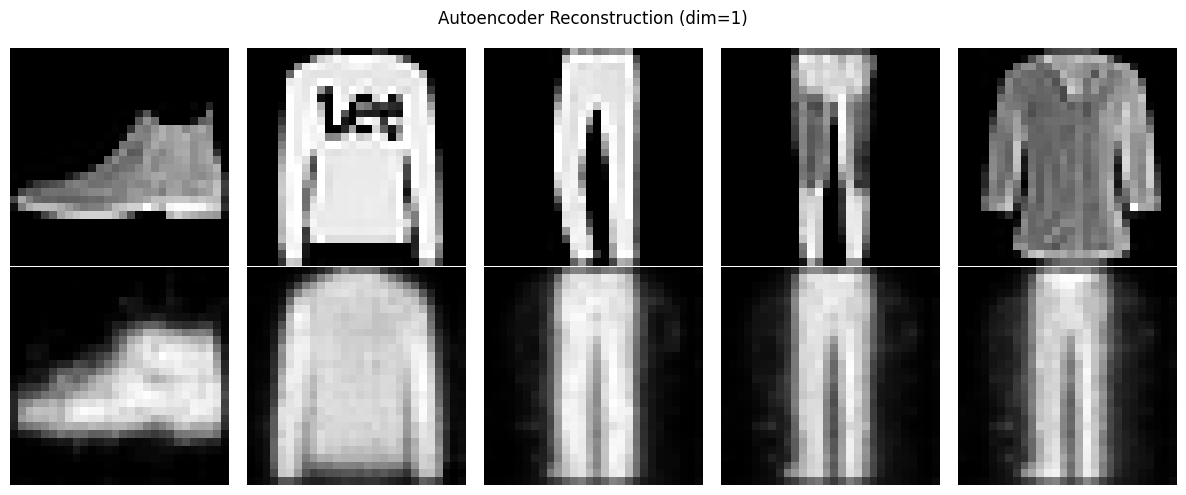


Dimensionality: 2


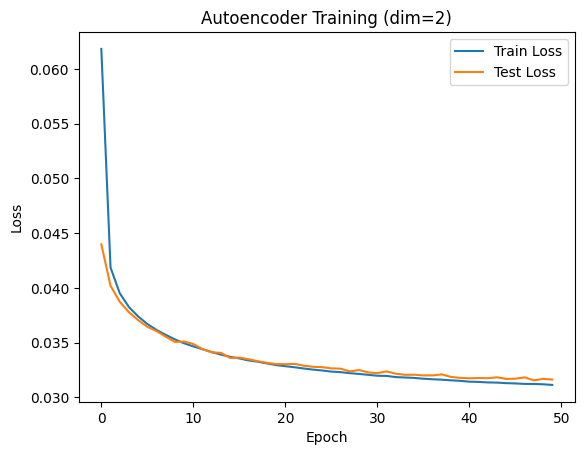

CAE Reconstruction Error (50 epochs): 0.031627


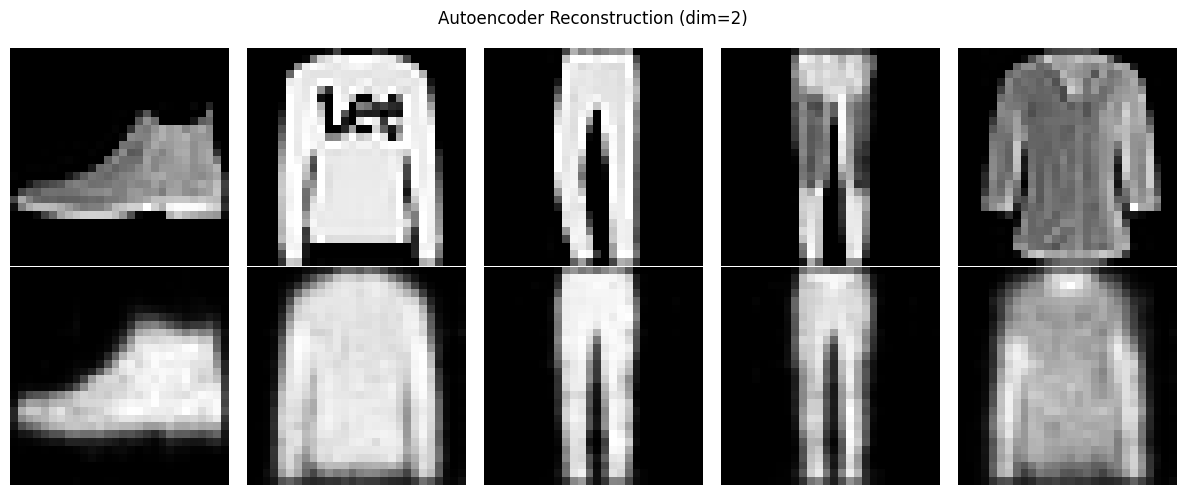


Dimensionality: 3


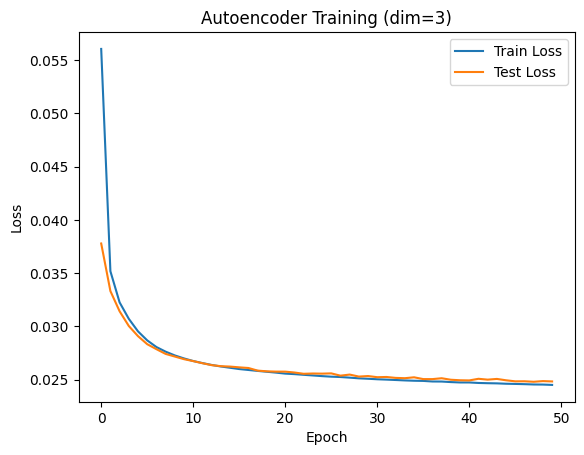

CAE Reconstruction Error (50 epochs): 0.024834


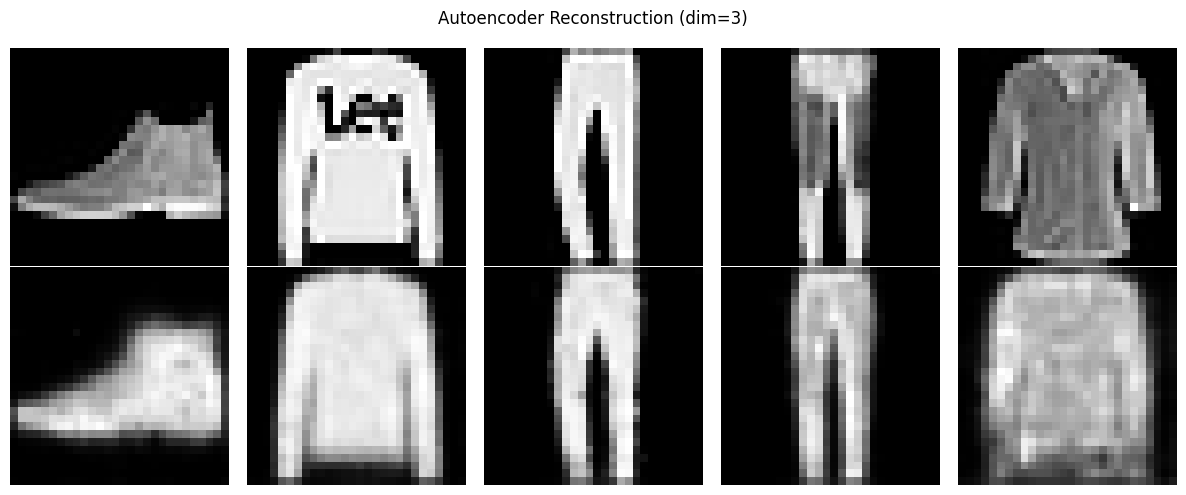

In [10]:
for dim in [1, 2, 3]:
    print(f"\nDimensionality: {dim}")
    
    # Autoencoder
    model = Autoencoder(dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, num_epochs, optimizer, criterion)
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Autoencoder Training (dim={dim})')
    plt.show()

    print(f"CAE Reconstruction Error (50 epochs): {test_losses[-1]:.6f}")
    
    model.eval()
    with torch.no_grad():
        test_samples = next(iter(test_loader))[0][:5].to(device)
        reconstructed = model(test_samples)
    
    visualize_results(test_samples.cpu(), reconstructed.cpu(), "Autoencoder", dim)
    

Key aspects of this implementation:

1. We use a loop to iterate through different dimensions, allowing for easy comparison.
2. For PCA, we utilize scikit-learn's implementation, applying it to flattened image data.
3. For the autoencoder, we create a new model for each dimension, train it, and evaluate its performance.
4. We use our previously defined visualization function to display results for both methods.

By structuring our experiments this way, we can efficiently compare PCA and autoencoder performance across various dimensions. This comprehensive analysis provides insights into the strengths and weaknesses of each method in the context of image data compression and reconstruction.


## Save the model

In [11]:
# Save the final model
# torch.save(model.state_dict(), f'autoencoder_model_dim{dim}.pth')